# Training Q Model
## Load Files

In [2]:
from FileUtils import FileUtils
import matplotlib.pyplot as plt 

In [3]:
data = FileUtils()
data.filter_by_class("cat")

Start to load data
Start to load images: 1000=>2000=>3000=>4000=>5000=>6000=>7000=>8000=>9000=>10000=>11000=>11540!
Start to load annotations: 1000=>2000=>3000=>4000=>5000=>6000=>7000=>8000=>9000=>10000=>11000=>11540!
End


In [4]:
len(data.images) # the length of the cat images

1084

## Model Loading

In [5]:
from Models import QModel
from Settings import Settings
import torch
import torch.optim as optim

In [6]:
device = torch.device("cuda" if Settings.cuda else "cpu")

In [7]:
policy_model = QModel()
# target_model = QModel()
# target_model.load_state_dict(policy_model.state_dict())

policy_model.cuda()
# target_model.cuda()
# target_model.eval()

QModel(
  (model): Sequential(
    (0): Linear(in_features=25112, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=1024, out_features=6, bias=True)
  )
)

In [8]:
from ReplayMemory import ReplayMemory
memory = ReplayMemory(1000)

In [9]:
optimizer = optim.RMSprop(policy_model.parameters())

## Training Loop

In [10]:
import time
from Agent import Agent
from IoU import *
from TrainUtils import optimize_model
import json

In [11]:
epoch_num = 100
eps = Settings.eps_start

In [12]:
Settings.target_update

3

In [14]:
print("Start Model Training")
loss_list = list()
for epoch in range(epoch_num):
    print("==> Epoch {} start ...".format(epoch))
    start = time.time()
    cur_loss = 0.0
    
    for i, image in enumerate(data.images[:1000]):
        annotation_list = data.annotations[i]
        agent = Agent(image)
        done = False
        old_iou_list = None
        cur_state = None
        
        for step in range(Settings.max_step):
            
            iou_list = [iou_calculator(agent.boundary, x) for x in annotation_list]
            max_index = max(range(len(iou_list)), key=lambda x: iou_list[x])
            iou = max(iou_list)
            old_iou = old_iou_list[max_index] if old_iou_list else 0
            old_iou_list = iou_list
            
            cur_state = agent.get_state() if step == 0 else cur_state # current state
            
            # determine if we should end the result 
            if iou > Settings.iou_threshold:
                action = torch.tensor(6).to(device)
            else:
                action = agent.get_next_action(policy_model, eps)

            if action == 6:
                reward = reward_terminal(iou)
                done = True
                next_state = None
            else:
                agent.hierarchical_move(action)
                agent.update_history_vector(action)
                if agent.sub_image.shape[0] * agent.sub_image.shape[1] == 0:
                    done = True
                    next_state = None
                else:
                    next_state = agent.get_state()
                    reward = reward_move(old_iou, iou)
            
            
            memory.push(cur_state, action, next_state, reward)
            cur_state = next_state
            
#             cur_loss = optimize_model(policy_model, target_model, memory, optimizer)
            cur_loss = optimize_model(policy_model, memory, optimizer)
            
            if done:
                break
                
#     if epoch % 1 == 0:
#         print("Update Network")
#         target_model.load_state_dict(policy_model.state_dict())
    loss_list.append(cur_loss)

    # save logs
    with open("{}log.json".format(Settings.model_path), "w") as f:
        json.dump(loss_list, f)

    with open("{}model{}.pt".format(Settings.model_path, epoch), 'wb') as f:
            torch.save(policy_model.cpu().state_dict(), f)
            if Settings.cuda:
                policy_model.cuda()

#     target_model.eval()
        
    if eps > 0.11:
        eps -= 0.1
    else:
        eps = 0.1
    
    time_cost = time.time() - start
    print("==> Epoch {} End, time cost = {}, current loss = {}, next eps = {}".format(epoch, round(time_cost,4), cur_loss, round(eps,2)))


Start Model Training
==> Epoch 0 start ...
==> Epoch 0 End, time cost = 43.1303, current loss = 1.1126, next eps = 0.8
==> Epoch 1 start ...
==> Epoch 1 End, time cost = 42.5094, current loss = 1.0462, next eps = 0.7
==> Epoch 2 start ...
==> Epoch 2 End, time cost = 46.4034, current loss = 1.2321, next eps = 0.6
==> Epoch 3 start ...
==> Epoch 3 End, time cost = 48.9088, current loss = 1.0535, next eps = 0.5
==> Epoch 4 start ...
==> Epoch 4 End, time cost = 51.1008, current loss = 0.9564, next eps = 0.4
==> Epoch 5 start ...
==> Epoch 5 End, time cost = 53.0756, current loss = 0.9969, next eps = 0.3
==> Epoch 6 start ...
==> Epoch 6 End, time cost = 56.1601, current loss = 1.1822, next eps = 0.2
==> Epoch 7 start ...
==> Epoch 7 End, time cost = 59.3011, current loss = 0.8611, next eps = 0.1
==> Epoch 8 start ...
==> Epoch 8 End, time cost = 60.4335, current loss = 1.1087, next eps = 0.1
==> Epoch 9 start ...
==> Epoch 9 End, time cost = 61.2564, current loss = 1.252, next eps = 0.1


KeyboardInterrupt: 

# Test Model

In [ ]:
def testModelOnOneImage(image_index):
    

In [ ]:
plt.imshow(data.images[17])

Step 0=>current iou = 0.31824 || current action = 5 || current reward = 1.0
Step 1=>current iou = 0.3481436505527082 || current action = 5 || current reward = 1.0
Step 2=>current iou = 0.29806934522813994 || current action = 5 || current reward = -1.0
Step 3=>current iou = 0.2398168271730879 || current action = 2 || current reward = -1.0
Step 4=>current iou = 0.24273384750159077 || current action = 1 || current reward = 1.0


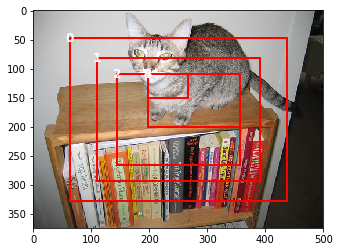

In [15]:
from Image import Image
image = Image(data, 49)
annotation_list = image.objects
agent = Agent(image.image)
done = False

for step in range(Settings.max_step):
    print("Step {}".format(step), end="=>")
    

    iou_list = [iou_calculator(agent.boundary, x) for x in annotation_list]
    max_index = max(range(len(iou_list)), key=lambda x: iou_list[x])
    iou = max(iou_list)
    
    print("current iou = {}".format(iou), end=" || ")
    old_iou = old_iou_list[max_index] if old_iou_list else 0
    old_iou_list = iou_list

    cur_state = agent.get_state()

    # determine if we should end the result 
    if iou > Settings.iou_threshold:
        action = torch.tensor(6).to(device)
    else:
        action = agent.get_next_action(policy_model, eps=0)

    if action == 6:
        reward = reward_terminal(iou)
        done = True
        next_state = None
    else:
        agent.hierarchical_move(action)
        agent.update_history_vector(action)
        image.draw_one_box(agent.boundary)
        image.add_text(step, (agent.boundary["xmin"], agent.boundary["ymin"]))
        if agent.sub_image.shape[0] * agent.sub_image.shape[1] == 0:
            done = True
            next_state = None
        else:
            next_state = agent.get_state()
            reward = reward_move(old_iou, iou)
            
    print("current action = {}".format(int(action)), end=" || ")
    print("current reward = {}".format(float(reward)))
    if done:
        break
image.show()    

In [ ]:
loss_list = [1,2,3]
import json

In [ ]:
with open("{}log.json".format(Settings.model_path), "w") as f:
    json.dump(loss_list, f)

In [ ]:
plt.plot(loss_list)